# Part 2: other environments and RL training
---

In this notebook we will go over some of the variations of `greenCrabEnv` available in this package, and over the syntax for training RL algorithms on instances of these environments.

## 0. Setup
---
As with Part 1 of this series, uncomment the following cell in order to install our package if you haven't done so already. After that restart the jupyter kernel.

In [45]:
%pip install -e ..

ERROR! Session/line number was not unique in database. History logging moved to new session 28
Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1074 sha256=46b47c20bfdf336611ec29790b08bfa8d5e9c4a12f0137341046fa15553bc1e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-qifuj75m/wheels/e9/7e/e6/00c4b11a2574abd59d64425d537139e25fadbde37f002c4dba
Successfully built rl4greencrab
  Attempting uninstall: rl4greencrab
    Found existing installation: rl4greencrab 1.0.0
    Uninstalling rl4greencrab-1.0.0:
      Successfully uninstalled rl4greencrab-1.0.0
Note: you may need to restart the kernel to use 

In [46]:
%pip install gym
%pip install optuna
%pip install rl_zoo3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs, theme, facet_wrap

from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env

from rl4greencrab import greenCrabSimplifiedEnv, simulator
import gym

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances

## 1. Other envs
---

We will go over two other envs provided by our package: `greenCrabSimplifiedEnv` and `timeSeriesEnv`.
Let's focus on the first one of these envs.

### greenCrabSimplifiedEnv

`greenCrabSimplifiedEnv` is closely related to `greenCrabEnv` and only varies in small aspects.
Let's examine these aspecs one by one.
The first aspect is its action space:

In [2]:
gcse = greenCrabSimplifiedEnv()
gcse.action_space

Box(-1.0, 1.0, (3,), float32)

Actions in this `greenCrabSimplifiedEnv` are between -1 and +1 (in contrast to `greenCrabEnv` where they were in [0, 2000]). 
This difference in action space is purely conceptual: we linearly associate the segment [-1, 1] to the segment [0, 2000] so that, e.g., an action of -1 corresponds to 0 traps laid, an action of 0 corresponds to 1000 traps laid, and an action of +1 corresponds to 2000 traps laid.
Mathematically, this transformation is:
$$a = A / 1000 - 1$$,
where $A\in[0,2000]$ and $a\in[-1,1]$.
This transformation of action space is performed because of purely computational reasons related to hyperparameter tuning of RL algorithms.

A second difference of `greenCrabSimplifiedEnv` with respect to `greenCrabEnv` is in its observation space.

In [5]:
gcse.observation_space

Box(-1.0, 1.0, (2,), float32)

In [6]:
gcse.reset()

(array([-1., -1.], dtype=float32), {})

Here, observations are vectors with *three* components instead of nine, and they are [-1, 1] valued.
E.g., consider the following observation after a second time-step:

In [7]:
gcse.step(np.float32([-0.5, -0.5, -0.5]))[0], gcse.step(np.float32([-0.5, -0.5, -0.5]))[0], gcse.step(np.float32([-0.5, -0.5, -0.5]))[0]

(array([-1., -1.], dtype=float32),
 array([-0.99996, -0.9998 ], dtype=float32),
 array([-0.99928, -0.99848], dtype=float32))

These three numbers correspond to: 1. the catch per 100 traps in the first five months of the year, 2. the catch per 100 traps in the later four months of the year, 3. the number of traps.
These three numbers are transformed to [-1, 1] in a similar fashion to eq. (1).

This simplifies the observations, making it easier for RL algorithms to exploit the information they provide.
Because of this, we will train our algorithms on `greenCrabSimplifiedEnv` rather than `greenCrabEnv`.

### timeSeriesEnv

TBD.

## 2. Training and evaluating RL algos
---

Here we cover some basic syntax for training RL algorithms on our envs.
We use short train times for the sake of brevity in this example.
Typical run-times might need upwards of 1 million time-steps, or possibly up to 10 million time-steps to converge.
This number will, however, depend on the particular algorithm used.

**Note:** This package also provides a more ergonomic syntax for training through the `train.py` script. 
To train models this way, run the following command on the terminal:

`python scripts/train.py -f hyperpars/ppo-gcse.yml`

There, we encode the input to the training algorithm as a YAML file.

In [16]:
gcse = greenCrabSimplifiedEnv()
vec_env = make_vec_env(greenCrabSimplifiedEnv, n_envs=12)
eval_envs = vec_env

### Config

In [22]:
N_TRIALS = 100  # Maximum number of trials
N_JOBS = 1 # Number of jobs to run in parallel
N_STARTUP_TRIALS = 5  # Stop random sampling after N_STARTUP_TRIALS
N_EVALUATIONS = 2  # Number of evaluations during the training
N_TIMESTEPS = 20_000  # Training budget
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_ENVS = 12
N_EVAL_EPISODES = 10
TIMEOUT = int(60 * 15)  # 15 minutes

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": gcse,
    "tensorboard_log": "/home/rstudio/logs"
}

### Define Search Space

In [18]:
from typing import Any, Dict

import optuna
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from torch import nn as nn
import gym
from rl_zoo3 import linear_schedule

def sample_ppo_params(trial: optuna.Trial, n_envs: int) -> Dict[str, Any]:
    """
    Sampler for PPO hyperparams.

    :param trial:
    :return:
    """
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])
    n_steps = trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048])
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    clip_range = trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3, 0.4])
    n_epochs = trial.suggest_categorical("n_epochs", [1, 5, 10, 20])
    gae_lambda = trial.suggest_categorical("gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0])
    max_grad_norm = trial.suggest_categorical("max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5])
    vf_coef = trial.suggest_float("vf_coef", 0, 1)
    net_arch_type = trial.suggest_categorical("net_arch", ["tiny", "small", "medium"])
    # Uncomment for gSDE (continuous actions)
    # log_std_init = trial.suggest_float("log_std_init", -4, 1)
    # Uncomment for gSDE (continuous action)
    # sde_sample_freq = trial.suggest_categorical("sde_sample_freq", [-1, 8, 16, 32, 64, 128, 256])
    # Orthogonal initialization
    ortho_init = False
    # ortho_init = trial.suggest_categorical('ortho_init', [False, True])
    # activation_fn = trial.suggest_categorical('activation_fn', ['tanh', 'relu', 'elu', 'leaky_relu'])
    activation_fn_name = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
    # lr_schedule = "constant"
    # Uncomment to enable learning rate schedule
    # lr_schedule = trial.suggest_categorical('lr_schedule', ['linear', 'constant'])
    # if lr_schedule == "linear":
    #     learning_rate = linear_schedule(learning_rate)

    # TODO: account when using multiple envs
    if batch_size > n_steps:
        batch_size = n_steps

    # Independent networks usually work best
    # when not working with images
    net_arch = {
        "tiny": dict(pi=[64], vf=[64]),
        "small": dict(pi=[64, 64], vf=[64, 64]),
        "medium": dict(pi=[256, 256], vf=[256, 256]),
    }[net_arch_type]

    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}[activation_fn_name]
    return {
        "n_steps": n_steps,
        "batch_size": batch_size,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "gae_lambda": gae_lambda,
        "max_grad_norm": max_grad_norm,
        "vf_coef": vf_coef,
        # "sde_sample_freq": sde_sample_freq,
        "policy_kwargs": dict(
            # log_std_init=log_std_init,
            net_arch=net_arch,
            activation_fn=activation_fn,
            ortho_init=ortho_init,
        ),
    }

### define objective function

In [19]:
from stable_baselines3.common.callbacks import EvalCallback

class TrialEvalCallback(EvalCallback):
    """
    Callback used for evaluating and reporting a trial.
    
    :param eval_env: Evaluation environement
    :param trial: Optuna trial object
    :param n_eval_episodes: Number of evaluation episodes
    :param eval_freq:   Evaluate the agent every ``eval_freq`` call of the callback.
    :param deterministic: Whether the evaluation should
        use a stochastic or deterministic policy.
    :param verbose:
    """

    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):

        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Evaluate policy (done in the parent class)
            super()._on_step()
            self.eval_idx += 1
            # Send report to Optuna
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True

In [20]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function using by Optuna to evaluate
    one configuration (i.e., one set of hyperparameters).

    Given a trial object, it will sample hyperparameters,
    evaluate it and report the result (mean episodic reward after training)

    :param trial: Optuna trial object
    :return: Mean episodic reward after training
    """

    kwargs = DEFAULT_HYPERPARAMS.copy() 
    ### YOUR CODE HERE
    # TODO: 
    # 1. Sample hyperparameters and update the default keyword arguments: `kwargs.update(other_params)`
    # 2. Create the evaluation envs
    # 3. Create the `TrialEvalCallback`

    # 1. Sample hyperparameters and update the keyword arguments
    kwargs.update(sample_ppo_params(trial,N_EVAL_ENVS))
    # Create the RL model
    model = PPO(**kwargs)

    # 2. Create envs used for evaluation using `make_vec_env`, `ENV_ID` and `N_EVAL_ENVS`
    eval_env = greenCrabSimplifiedEnv()
    # 3. Create the `TrialEvalCallback` callback defined above that will periodically evaluate
    # and report the performance using `N_EVAL_EPISODES` every `EVAL_FREQ`
    # TrialEvalCallback signature:
    # TrialEvalCallback(eval_env, trial, n_eval_episodes, eval_freq, deterministic, verbose)
    eval_callback = TrialEvalCallback(eval_env, trial, N_EVAL_EPISODES, EVAL_FREQ, deterministic=True)

    ### END OF YOUR CODE

    nan_encountered = False
    try:
        # Train the model
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN
        print(e)
        nan_encountered = True
    finally:
        # Free memory
        model.env.close()
        vec_env.close()

    # Tell the optimizer that the trial failed
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward

[I 2024-05-19 04:34:54,339] A new study created in memory with name: no-name-2e727716-d268-41c7-bb8a-3dc52bc32cec


/opt/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode 
lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor``
wrapper.

[I 2024-05-19 04:35:59,163] Trial 0 finished with value: -253.01804021329153 and parameters: {'batch_size': 64, 'n_steps': 1024, 'gamma': 0.9, 'learning_rate': 0.002331380679676563, 'ent_coef': 0.006569281847871193, 'clip_range': 0.2, 'n_epochs': 20, 'gae_lambda': 0.98, 'max_grad_norm': 1, 'vf_coef': 0.8120413779383655, 'net_arch': 'medium', 'activation_fn': 'relu'}. Best is trial 0 with value: -253.01804021329153.
[I 2024-05-19 04:36:35,172] Trial 1 finished with value: -1499.814338874817 and parameters: {'batch_size': 64, 'n_steps': 2048, 'gamma': 0.9, 'learning_rate': 0.0053561212974118175, 'ent_coef': 2.744105845335391e-08, 'clip_range': 0.1, 'n_epochs': 1, 'gae_lambda': 0.99, 'max_grad_norm': 1, 'vf_coef': 0.5931531691879838, 'net_arch': 'small', 'activation_fn': 'relu'}. Best is trial 0 with value: -253.01804021329153.
[I 2024-05-19 04:37:08,326] Trial 2 finished with value: -454.4768619060516 and parameters: {'batch_size': 512, 'n_steps': 256, 'gamma': 0.999, 'learning_rate': 0.

Number of finished trials:  13

Best trial:

Value: -252.87746716563123

Params:

batch_size: 64

n_steps: 512

gamma: 0.9

learning_rate: 1.7981161785233295e-05

ent_coef: 1.706637615300967e-08

clip_range: 0.4

n_epochs: 20

gae_lambda: 0.8

max_grad_norm: 5

vf_coef: 0.7807332338047879

net_arch: tiny

activation_fn: tanh

User attrs:

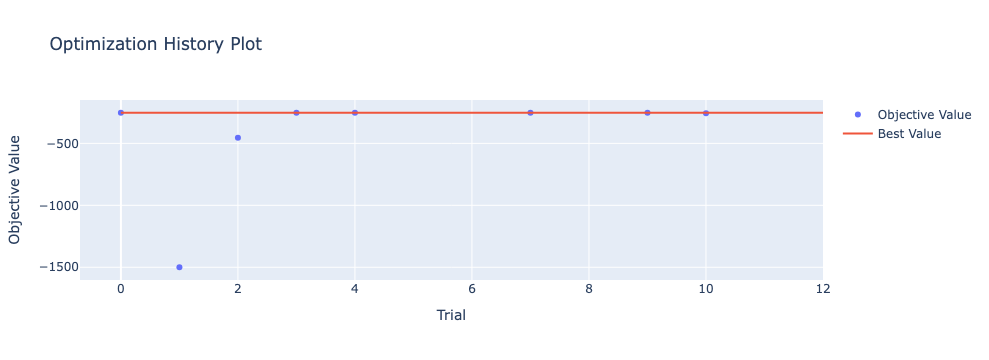

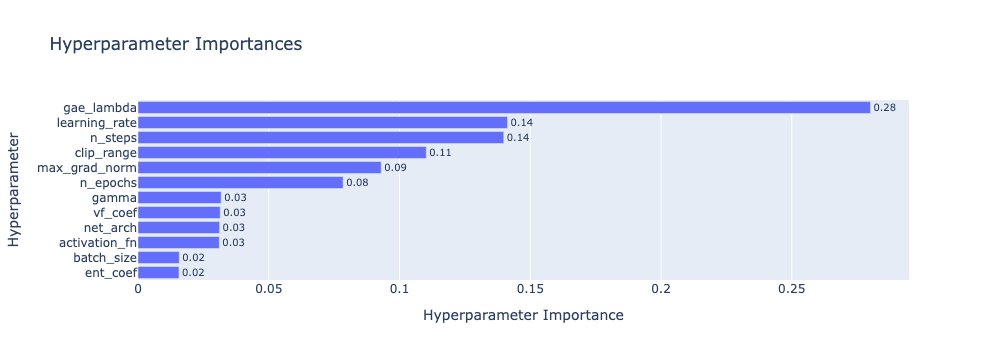

In [23]:
import torch as th

# Set pytorch num threads to 1 for faster training
th.set_num_threads(1)
# Select the sampler, can be random, TPESampler, CMAES, ...
sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# Do not prune before 1/3 of the max budget is used
pruner = MedianPruner(
    n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3
)
# Create the study and start the hyperparameter optimization
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")

try:
    study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_JOBS, timeout=TIMEOUT)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print(f"    {key}: {value}")

# Write report
study.trials_dataframe().to_csv("study_results_a2c_cartpole.csv")

fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

fig1.show()
fig2.show()

### PPO

In [6]:
model = PPO("MlpPolicy", vec_env, verbose=0, 
            batch_size =  64, 
            n_steps = 32, 
            gamma = 0.95, 
            # learning_rate = 0.9447561168646137, 
            ent_coef = 7.676877009214456e-07, 
            clip_range =  0.1, 
            n_epochs = 20, 
            gae_lambda = 0.9, 
            max_grad_norm = 5, 
            vf_coef = 0.9694540149524578, 
            tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("ppo_gcse")

LiveError: Only one live display may be active at once

### TD3

In [7]:
model = TD3("MlpPolicy", gcse, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("td3_gcse")

LiveError: Only one live display may be active at once

### TQC

In [21]:
model = TQC("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("tqc_gcse")

Output()

## 3. Loading and evaluating RL algos
---

In [10]:
ppoAgent = PPO.load("ppo_gcse")
td3Agent = TD3.load("td3_gcse")
tqcAgent = TQC.load("tqc_gcse")
evalEnv = greenCrabSimplifiedEnv()

In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

### PPO

In [12]:
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


PPO reward = -342.68172 +/- 0.15548


### TD3

In [6]:
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TD3 reward = -0.33306 +/- 0.00161


### TQC

In [7]:
mean_rew, std_rew = evaluate_policy(tqcAgent, evalEnv)
print(f"TQC reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TQC reward = -0.47400 +/- 0.00035


## 4. Timeseries of episodes
---

### PPO

In [16]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,0.000958,0.001571,-0.422949,0.000000,0
1,1,-1.000000,-1.000000,0.000958,0.001571,-0.422949,-29.855026,0
2,2,-1.000000,-0.999880,0.000958,0.001571,-0.422931,-59.712040,0
3,3,-0.999540,-0.999041,0.000956,0.001568,-0.422752,-89.577981,0
4,4,-0.998282,-0.998022,0.000954,0.001563,-0.422462,-119.488966,0


<Axes: xlabel='t'>

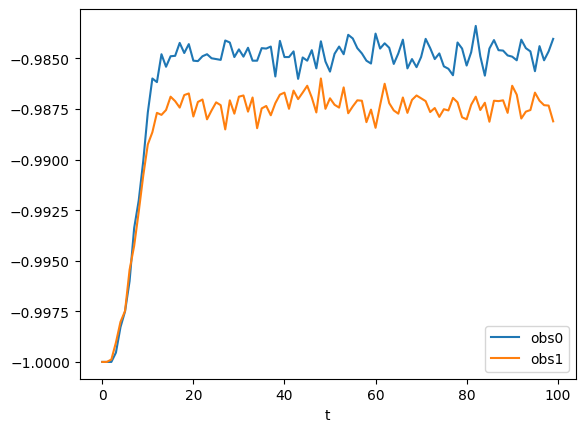

In [18]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1'])

<Axes: xlabel='t'>

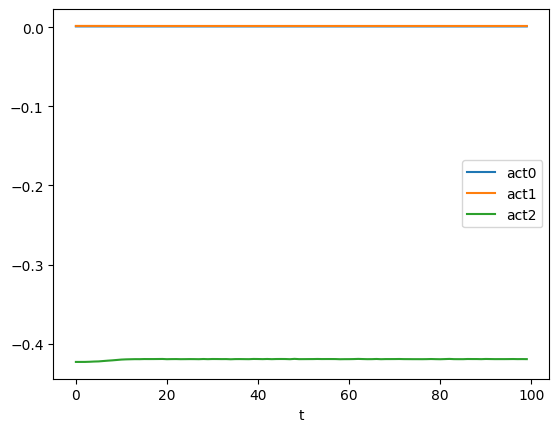

In [26]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

### TD3

(<Axes: xlabel='t'>, <Axes: xlabel='t'>)

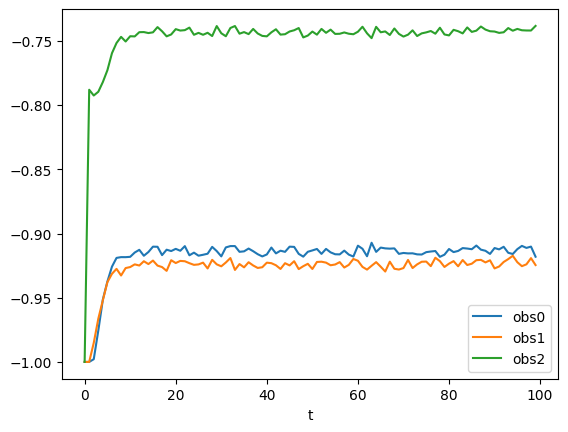

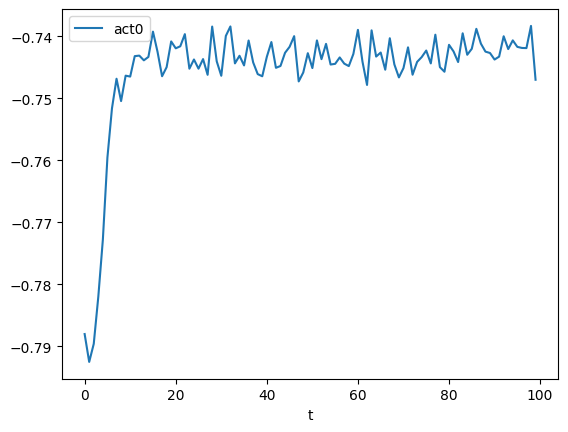

In [9]:
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
(
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['obs0', 'obs1', 'obs2']),
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0']),
)